## Univariate ts example using exogenous variables:

In this notebook we will show how to prepare data to be consumed by the trainer.
Note that the main parts are: 
- a dictionary, which contains all relevant information
necessary for training (like number of ts, prediction length and frequency of data)
- the ListDataset, which is used to prepare the train and test datasets.

Additionally we show how to return the different quantiles of the predictor for better transparency.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

from pts.model.deepar import DeepAREstimator
from pts import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts import time_feature
import json
from itertools import islice
from gluonts.dataset.field_names import FieldName

/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [16]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00549/HortonGeneralHospital.csv"
df = pd.read_csv(url, index_col=0)
df.shape

(139, 6)

In [54]:
# normalize input data: 
# here this step might not be necessary,
# but in general normalizing input data
# when working with neural nets is important:

input_cols = ['Cardio', 'Resp', 'Hypo']

norm_df = df[input_cols].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
final_df = pd.concat([df['Adm'], norm_df], ignore_index=False, sort=False, axis=1)

In [55]:
final_df.describe()

,Adm,Cardio,Resp,Hypo
count,139.000000,139.000000,139.000000,139.000000
mean,534.985612,0.287770,0.062950,0.086331
std,73.129524,0.284323,0.141465,0.281868
min,373.000000,0.000000,0.000000,0.000000
25%,491.500000,0.000000,0.000000,0.000000
50%,539.000000,0.333333,0.000000,0.000000
75%,579.000000,0.333333,0.000000,0.000000
max,724.000000,1.000000,1.000000,1.000000


In [118]:
# define the parameters of the dataset:

custom_ds_metadata = {
    'num_series': 1, # because we have only one target ts
    'num_steps': final_df.shape[0], # defines the length of the ts
    'prediction_length': 24, # number of steps we want to predict
    'freq': 'M', # data is given per month --> M
    'start': [
        pd.Timestamp('1999-11-01', freq='M')
        for _ in range(final_df.shape[0])
    ]
}

/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  # Remove the CWD from sys.path while we load stuff.


In [119]:
# define target and features to be used:
target = np.array([df['Adm']])

feat_dynamic_real = np.array([df['Hypo'],df['Cardio'],df['Hypo']])

In [120]:
# Define fields used
# Here we define a dynamic_real value on top of the target
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr]
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target[:, :-custom_ds_metadata['prediction_length']],
            custom_ds_metadata['start'],
            feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']]
            #feat_static_cat
        )
    ],
    freq=custom_ds_metadata['freq']
)

# test
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr]
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target,
            custom_ds_metadata['start'],
            feat_dynamic_real
            #feat_static_cat
            )
    ],
    freq=custom_ds_metadata['freq']
)

In [121]:
# Returning train and test dict:

train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

print(test_entry.keys(), train_entry.keys())

dict_keys(['target', 'start', 'feat_dynamic_real', 'source']) dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])


/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/dataset/common.py:337: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return timestamp.freq.rollforward(timestamp)


In [122]:
# look at the first train entry:
train_entry

{'target': array([413., 443., 378., 385., 388., 406., 409., 425., 453., 411., 407.,
        417., 422., 426., 427., 410., 450., 449., 438., 446., 460., 437.,
        475., 464., 467., 499., 459., 461., 488., 486., 515., 457., 558.,
        519., 509., 519., 544., 532., 509., 532., 598., 495., 543., 555.,
        553., 532., 579., 633., 622., 644., 624., 553., 628., 671., 713.,
        684., 724., 655., 714., 664., 589., 567., 617., 542., 565., 592.,
        635., 567., 598., 514., 551., 613., 499., 537., 533., 490., 567.,
        538., 506., 529., 548., 564., 522., 537., 559., 579., 560., 493.,
        570., 519., 512., 539., 556., 532., 539., 593., 551., 559., 480.,
        474., 523., 510., 503., 498., 532., 530., 550., 561., 550., 637.,
        603., 520., 624., 596., 656.], dtype=float32),
 'start': Timestamp('1999-11-30 00:00:00', freq='M'),
 'feat_dynamic_real': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 1., 1., 0., 0., 0., 0.

In [129]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

estimator = DeepAREstimator(freq=custom_ds_metadata['freq'],
                            prediction_length=custom_ds_metadata['prediction_length'],
                            input_size=22,
                            num_layers=2,
                            num_cells=40,
                            use_feat_dynamic_real=True,
                            context_length=2*custom_ds_metadata['prediction_length'],
                            trainer=Trainer(epochs=5,
                                            learning_rate=1e-3,
                                            num_batches_per_epoch=128,
                                            batch_size=64,
                                            device=device))

predictor = estimator.train(training_data=train_ds, 
                            num_workers=0
                           )

  0%|          | 0/127 [00:00<?, ?it/s]

/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

In [130]:
# return model input params:

print(predictor.input_names)
print()
print(estimator.time_features)
print()
print(predictor.freq)
print()
print(estimator.use_feat_dynamic_real)

['feat_static_cat', 'feat_static_real', 'past_time_feat', 'past_target', 'past_observed_values', 'future_time_feat']

[gluonts.time_feature._base.MonthOfYear()]

M

True


In [131]:
# Return forcast and compare with true values:

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|█████████████████████████| 1/1 [00:00<00:00, 19.97it/s]/Users/janrathfelder/opt/anaconda3/envs/py37/lib/python3.7/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq



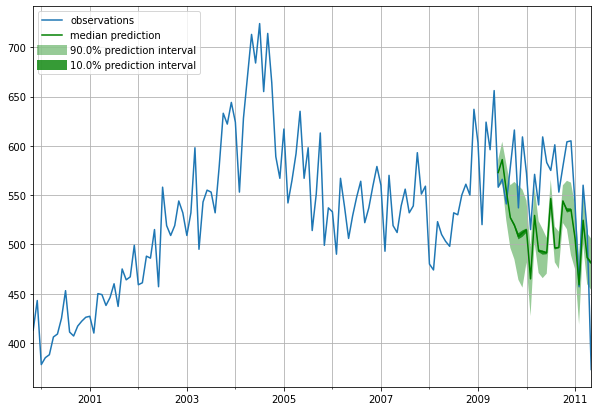

In [132]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (10.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

forecast_entry = forecasts[0]
ts_entry = tss[0]
plot_prob_forecasts(ts_entry, forecast_entry) 

In [133]:
# Print errors:

print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 3994.0787760416665,
    "abs_error": 1298.376220703125,
    "abs_target_sum": 13358.0,
    "abs_target_mean": 556.5833333333334,
    "seasonal_error": 56.38834951456311,
    "MASE": 0.959400473000042,
    "MAPE": 0.09766241908073425,
    "sMAPE": 0.10142195224761963,
    "MSIS": 17.495262405213353,
    "QuantileLoss[0.1]": 487.13342895507816,
    "Coverage[0.1]": 0.125,
    "QuantileLoss[0.2]": 750.7552124023439,
    "Coverage[0.2]": 0.16666666666666666,
    "QuantileLoss[0.3]": 966.4718872070312,
    "Coverage[0.3]": 0.16666666666666666,
    "QuantileLoss[0.4]": 1147.3893310546875,
    "Coverage[0.4]": 0.16666666666666666,
    "QuantileLoss[0.5]": 1298.3761596679688,
    "Coverage[0.5]": 0.20833333333333334,
    "QuantileLoss[0.6]": 1425.0341064453123,
    "Coverage[0.6]": 0.20833333333333334,
    "QuantileLoss[0.7]": 1513.4827270507812,
    "Coverage[0.7]": 0.20833333333333334,
    "QuantileLoss[0.8]": 1509.951892089844,
    "Coverage[0.8]": 0.20833333333333334,
    "Qua

In [134]:
# Return predictions for further inspection:

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2009-06-30 00:00:00
Frequency of the time series: M


In [135]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")
print(f"0.1-quantile of the future window:\n {forecast_entry.quantile(0.1)}")
print(f"0.9-quantile of the future window:\n {forecast_entry.quantile(0.9)}")

Mean of the future window:
 [572.47217 584.4465  554.2723  526.8707  522.4857  510.79822 511.74
 513.4334  464.51523 529.26624 494.41415 490.89938 489.96155 547.28674
 497.0909  496.01175 542.3618  535.3112  532.4699  505.83813 455.85953
 524.52515 484.00708 480.66406]
0.5-quantile (median) of the future window:
 [572.87604 585.9953  554.4788  527.08167 519.5565  507.93723 511.65347
 514.7348  464.98325 529.27716 493.16312 492.81738 491.41156 546.4128
 496.33926 496.81662 544.03534 534.3862  535.2574  506.3589  458.91696
 524.4264  486.52185 481.27994]
0.1-quantile of the future window:
 [560.2303  569.568   532.8864  508.41263 494.88892 477.15173 481.62463
 488.07156 441.09137 506.9778  473.97397 468.96722 474.69998 534.3367
 486.80487 480.10223 527.9691  519.47363 507.9938  478.56488 426.71765
 504.35995 463.4244  461.99734]
0.9-quantile of the future window:
 [581.36975 595.5836  576.462   552.0586  558.6715  542.5192  538.0657
 538.0107  485.17563 552.39874 515.6055  511.87323 501.